<a href="https://colab.research.google.com/github/mariabandeira/Projeto_Final_IIA/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Web scrapping Amazon reviews

In [ ]:
# fontes:
# https://www.kaggle.com/code/bhardwajshivam121/web-scrapping-amazon
# https://www.kaggle.com/code/nikhilraj7700/web-scrapping-code-python-beautifulsoup
# perplexity

import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL da página da Amazon
url = "https://www.amazon.com.br/dp/B09SWTG9GF?ref=ods_erd_dpcc_ttl_k11_rc_nd_ucc"

# Realizar uma solicitação HTTP para a página
response = requests.get(url)

# Verificar se a solicitação foi bem-sucedida
if response.status_code == 200:
    # Parsear o conteúdo HTML da página com BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    names = (soup.find_all('span',class_='a-profile-name'))

    cust_name = []
    for i in range(0,len(names)):
      #get_text() removes all the tags and extract text
      cust_name.append(names[i].get_text())

    title = list(soup.find_all(class_='review-title-content'))

    review_title = []
    for i in range(0,len(title)):
      review_title.append(title[i].get_text())

    #to remove '\n'from list of comment heading
    review_title[:] = [review_titles.rstrip('\n')
                for review_titles in review_title] #remove \n

    rating = list(soup.find_all(class_ = 'review-rating'))

    rate = []
    for i in range(0,len(rating)):
      rate.append(rating[i].get_text())

    rate = []
    for i in range(0,len(rating)):
      rate.append(rating[i].get_text()[0:1])

    new_rate = rate[2:12]

    df=pd.DataFrame()
    df['Customer Name'] = cust_name
    df['Review Title'] = review_title
    df['Rating'] = new_rate
    df

    # Criar um dicionário para armazenar as informações das reviews
    reviews_data = []

    # Encontrar a seção com as reviews
    reviews_section = soup.find('div', {'id': 'reviews'})

    # Encontrar as reviews individuais
    reviews = soup.find_all('div', {'data-hook': 'review'})
    for item in reviews:
        review={'body':item.find('span', {'data-hook': 'review-body'}).text.strip()}
        reviews_data.append(review)

    '''
    # Iterar sobre as reviews e extrair as informações
    for review in reviews:
        # Encontrar o título da review
        title = review.find('span', {'data-hook': 'review-title'}).text

        # Encontrar a nota da review
        rating = review.find('i', {'data-hook': 'review-rating'}).text

        # Encontrar o texto da review
        text = review.find('span', {'data-hook': 'review-body'}).text

        # Armazenar as informações da review no dicionário
        reviews_data.append({
            'title': title,
            'rating': rating,
            'text': text
        })
    '''
    # Criar um DataFrame com as informações das reviews
    reviews_df = pd.DataFrame(reviews_data)

    # Salvar o DataFrame em um arquivo CSV
    reviews_df.to_csv('amazon_reviews.csv', index=False)

else:
    print(f"Erro ao acessar a página: {response.status_code}")

ValueError: Length of values (3) does not match length of index (8)

## Sentiment Analysis

In [ ]:
!pip install nltk

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [ ]:
df = pd.read_csv()

In [ ]:
df.head()

In [ ]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='', figsize=(10,5))
ax.set_xlabel('')
plt.show()

### Basic NLTK

In [ ]:
example = df['Text'][50]
print(example)

In [ ]:
tokens = nltk.word_tokenize(example)

In [ ]:
#token pos
tagged = nltk.pos_tag(tokens)

In [ ]:
#
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint() #pretty print

### Vader Sentiment Scoring

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [ ]:
sia.polarity_scores('This is the worst thing ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [ ]:
sia.polarity_scores(example)

In [ ]:
# Run on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row['Text']
  myid = row['Id']
  res[myid] = sia.polarity_scores(text)

In [ ]:
from operator import index
vaders = pd.DataFrame(res).T
vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(df, how='left')

In [ ]:
# Sentiment Score and metadata
vaders

In [ ]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound score by Amazon Star Review')
plt.show()

In [ ]:
fig, axs = plt.subplotes(1, 3, figsize=(15, 5))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

### Pretrained Model

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}

In [ ]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
  }

  return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  try:
    text = row['Text']
    myid = row['Id']
    vader_result = sia.polarity_scores()
    vader_result_rename = {}
    for key, value in vader_result.items():
      vader_result_rename[f"vader_{key}"] = value
    roberta_result = polarity_scores_roberta(text)
    both = {**vader_result, **roberta_result}
    res[myid] = both
  except RuntimeError:
    print(f'Broke for id {myid}')

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(df, how='left')

### Combine and Compare

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

## Extra: the transformers pipeline

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [ ]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

In [ ]:
multilingual_classifier = pipeline('sentiment-analysis', model="nlptown/bert-base-multilingual-uncased-sentiment")

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
multilingual_classifier("Custo benefício bom, mas por ter escolhido o de cor preto não gostei que a fonte de energia tenha vindo na cor branca, ficou um tanto destoante.")

[{'label': '3 stars', 'score': 0.5764768123626709}]

In [ ]:
multilingual_classifier('Gostei da Echo Pop ...qualidade do material muito boa, recursos da Alexa ok...mas não espere um som potente como o da Echo dot por exemplo....mas pelo custo vale!')

[{'label': '4 stars', 'score': 0.5807279348373413}]

In [ ]:
multilingual_classifier('Produto chegou corretamente, funcionando normal. Mas não gostei da qualidade do som, para quem gosta de ouvir bem os graves/baixo a echo pop é muito ruim nesse quesito. Tentei ajusta as configurações de áudio no app da alexa e tb usar um app de equalizador, mesmo assim eu particularmente não gostei. Vou devolver o produto.')

[{'label': '2 stars', 'score': 0.5304345488548279}]

## Using Textblob

In [3]:
!pip install -U textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: textblob
    Found existing installation: textblob 0.17.1
    Uninstalling textblob-0.17.1:
      Successfully uninstalled textblob-0.17.1


In [4]:
!pip install deep-translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.5 MB/s eta 0:00:00


In [5]:
from textblob import TextBlob
from deep_translator import GoogleTranslator
import pandas as pd

In [32]:
tradutor = GoogleTranslator(source= "pt", target= "en")

In [33]:
text = "Eu ODEIO essa música! Mas a letra é muito boa"
traducao = tradutor.translate(text)
blob = TextBlob(traducao)

In [ ]:
# criar uma coluna com as reviews traduzidas para o inglês

In [34]:
sentiment = blob.sentiment
print(sentiment)

Sentiment(polarity=-0.04500000000000004, subjectivity=0.8400000000000001)


In [35]:
polarity = blob.sentiment.polarity
subjectivity = blob.sentiment.subjectivity

print(polarity)
print(subjectivity)

-0.04500000000000004
0.8400000000000001


In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/TailUFPB/AIpp/main/web/data/games.csv')

In [9]:
df

,reviews,score,likes,time,app_name,year,reviews_en
0,"Olá! Sei que é um app que está em teste, está ...",4,586,13/11/2021,Xbox Game Pass (Beta),2021,"Hello! I know it's an app that's being tested,..."
1,"O app é excelente, a questão é que existem alg...",4,369,19/07/2022,Xbox Game Pass (Beta),2022,"The app is excellent, the issue is that there ..."
2,"Sei que ainda está em beta mas, seria interess...",3,509,23/11/2021,Xbox Game Pass (Beta),2021,"I know it's still in beta, but it would be int..."
3,Ficou top o visual da nova versão. Deveriam un...,5,289,02/07/2020,Xbox Game Pass (Beta),2020,The look of the new version was top. They shou...
4,"O aplicativo é realmente muito bom, é o que to...",5,44,19/10/2021,Xbox Game Pass (Beta),2021,"The app is really good, it's what everyone exp..."
...,...,...,...,...,...,...,...
12231,Drird,5,0,14/05/2020,Steam Link,2020,Drird
12232,Paia,2,0,26/12/2021,Steam Link,2021,paia
12233,Gg,4,0,27/09/2019,Steam Link,2019,gg
12234,Amor,5,0,19/07/2018,Steam Link,2018,Love


In [10]:
def sentences_tokenization(text):
  sentences = []
  blob = TextBlob(text)
  for sentence in blob.sentences:
    sentences.append(str(sentence))

  return sentences

In [13]:
df['sentences_pt'] = df['reviews'].apply(sentences_tokenization)

In [16]:
df['sentences_en'] = df['reviews_en'].apply(sentences_tokenization)

In [14]:
def sentiment_analysis(sentences):
  sentiments = []
  for sentence in sentences:
    blob = TextBlob(sentence)
    sentiment = blob.sentiment.polarity
    sentiments.append(sentiment)

  return sentiments

In [17]:
df['sentences_sentiments'] = df['sentences_en'].apply(sentiment_analysis)

In [18]:
df['positive_sentences'] = df.apply(lambda x: [frase for frase, sentimento in zip(x['sentences_pt'], x['sentences_sentiments']) if sentimento > 0], axis=1)

In [19]:
df['negative_sentences'] = df.apply(lambda x: [frase for frase, sentimento in zip(x['sentences_pt'], x['sentences_sentiments']) if sentimento < 0], axis=1)

In [20]:
df

,reviews,score,likes,time,app_name,year,reviews_en,sentences_pt,sentences_en,sentences_sentiments,positive_sentences,negative_sentences
0,"Olá! Sei que é um app que está em teste, está ...",4,586,13/11/2021,Xbox Game Pass (Beta),2021,"Hello! I know it's an app that's being tested,...","[Olá!, Sei que é um app que está em teste, est...","[Hello!, I know it's an app that's being teste...","[0.0, 0.425, 0.7]","[Sei que é um app que está em teste, está bom,...",[]
1,"O app é excelente, a questão é que existem alg...",4,369,19/07/2022,Xbox Game Pass (Beta),2022,"The app is excellent, the issue is that there ...","[O app é excelente, a questão é que existem al...","[The app is excellent, the issue is that there...","[1.0, -0.35555555555555557, 0.7]","[O app é excelente, a questão é que existem al...","[Um exemplo é o Gears 5, que no Cloud Gaming d..."
2,"Sei que ainda está em beta mas, seria interess...",3,509,23/11/2021,Xbox Game Pass (Beta),2021,"I know it's still in beta, but it would be int...","[Sei que ainda está em beta mas, seria interes...","[I know it's still in beta, but it would be in...","[0.20238095238095236, 0.0, 0.2916666666666667]","[Sei que ainda está em beta mas, seria interes...",[]
3,Ficou top o visual da nova versão. Deveriam un...,5,289,02/07/2020,Xbox Game Pass (Beta),2020,The look of the new version was top. They shou...,"[Ficou top o visual da nova versão., Deveriam ...","[The look of the new version was top., They sh...","[0.3181818181818182, 0.0, -0.0866666666666667,...","[Ficou top o visual da nova versão., Fora isso...","[Está faltando visualizar as notas, opiniões d..."
4,"O aplicativo é realmente muito bom, é o que to...",5,44,19/10/2021,Xbox Game Pass (Beta),2021,"The app is really good, it's what everyone exp...","[O aplicativo é realmente muito bom, é o que t...","[The app is really good, it's what everyone ex...","[0.15833333333333333, 0.215, 0.0, 0.0]","[O aplicativo é realmente muito bom, é o que t...",[]
...,...,...,...,...,...,...,...,...,...,...,...,...
12231,Drird,5,0,14/05/2020,Steam Link,2020,Drird,[Drird],[Drird],[0.0],[],[]
12232,Paia,2,0,26/12/2021,Steam Link,2021,paia,[Paia],[paia],[0.0],[],[]
12233,Gg,4,0,27/09/2019,Steam Link,2019,gg,[Gg],[gg],[0.0],[],[]
12234,Amor,5,0,19/07/2018,Steam Link,2018,Love,[Amor],[Love],[0.5],[Amor],[]


In [12]:
import nltk
from nltk.tokenize import word_tokenize
import string
from textblob import TextBlob, Word
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [21]:
positive_text = [str(frase) for frase in df['positive_sentences']]
positive_text = ' '.join(positive_text)

negative_text = [str(frase) for frase in df['negative_sentences']]
negative_text = ' '.join(negative_text)

stopwords = nltk.corpus.stopwords.words('portuguese')
punctuation = string.punctuation

positive_text = positive_text.lower()
negative_text = negative_text.lower()

wp = Word(positive_text)
lemma_pos = TextBlob(positive_text)
" ". join([w.lemmatize() for w in lemma_pos.words])

wn = Word(negative_text)
lemma_neg = TextBlob(negative_text)
" ". join([w.lemmatize() for w in lemma_neg.words])

pos_tokens = word_tokenize(positive_text)
neg_tokens = word_tokenize(negative_text)

pos_tokens = [word for word in pos_tokens if word not in stopwords]
neg_tokens = [word for word in neg_tokens if word not in stopwords]

clean_pos_tokens = []
clean_neg_tokens = []

for token in pos_tokens:
    clean_token = ''.join(char for char in token if char not in punctuation)
    if clean_token:
        clean_pos_tokens.append(clean_token)

for token in neg_tokens:
    clean_token = ''.join(char for char in token if char not in punctuation)
    if clean_token:
        clean_neg_tokens.append(clean_token)

In [23]:
print(clean_pos_tokens)

['sei', 'app', 'teste', 'bom', 'sei', 'pode', 'melhorar', 'ainda', 'travamento', 'jogos', 'atraso', 'jogabilidade', 'imagens', 'qualidade', 'inferior', 'muitas', 'pessoas', 'jogando', 'tempo', 'creio', 'tudo', 'vai', 'melhorar', 'disponível', 'android', 'tv', 'smarttv', 'setupbox', 'opinião', 'melhor', 'experiência', 'todas', 'app', 'excelente', 'questão', 'existem', 'alguns', 'glitches', 'compatibilidade', 'games', 'touch', 'sei', 'ainda', 'beta', 'interessante', 'adicionar', 'suporte', 'toque', 'tela', 'todos', 'jogos', 'botões', 'básicos', 'pudéssemos', 'personalizar', 'posição', 'pois', 'certos', 'jogos', 'possível', 'jogar', 'botões', 'básicos', 'espero', 'dia', 'possa', 'possível', 'tornando', 'tudo', 'acessível', 'players', 'celular', 'ficou', 'top', 'visual', 'nova', 'versão', 'fora', 'cada', 'vez', 'ficando', 'melhor', 'recursos', 'xbox', 'isso', 'aí', 'microsoft', 'pare', 'inovar', 'melhorar', 'aplicativo', 'realmente', 'bom', 'todos', 'esperavam', 'reclamações', 'travamentos

In [24]:
print(clean_neg_tokens)

['um', 'exemplo', 'gears', '5', 'cloud', 'gaming', 'celular', 'possui', 'glitch', 'ato', 'final', 'campanha', 'deixa', 'impossível', 'zerar', 'game', 'celular', 'geral', 'equipe', 'cuida', 'desses', 'aplicativos', 'xbox', 'lenta', 'atualizações', 'bom', 'aplicativo', 'está', 'faltando', 'visualizar', 'notas', 'opiniões', 'jogos', 'principalmente', 'filtros', 'funcionalidades', 'encontrarmos', 'jogos', 'ex', 'hdr10', 'xbox', 'play', 'anywhere', 'multiplayer', 'local', 'coop', 'local', 'etc', 'jogo', 'age', 'of', 'empires', 'tá', 'narrador', 'ativado', 'desligar', 'sou', 'assinante', '1', 'ano', 'meio', 'quase', 'jogo', 'navegador', 'pq', 'defender', 'app', 'mal', 'otimizado', 'app', 'disponível', 'mi', 'stick', 'chromecast', 'um', 'dispositivo', 'conectado', 'bluetooth', 'imagem', 'fica', 'horrível', 'precisa', 'melhorar', 'qualidade', 'tá', 'caindo', 'gráfico', 'desempenho', 'horríveis', 'horrível', 'dá', 'pra', 'comprar', 'game', 'pass', 'app', 'recomendo', 'diz', 'bom', 'pq', 'proble

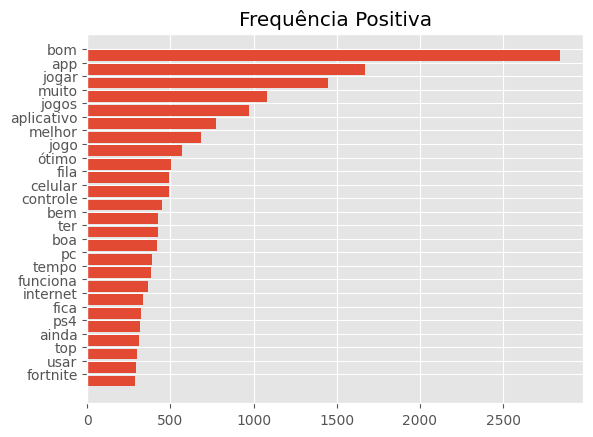

In [30]:
from collections import Counter

pos_freq = dict(Counter(clean_pos_tokens))
pos_freq.pop('q')
pos_freq.pop('pra')
pos_popular_words = sorted(pos_freq, key = pos_freq.get, reverse = True)

plt.barh(range(25), [pos_freq[w] for w in reversed(pos_popular_words[0:25])])
plt.yticks([x + 0.5 for x in range(25)], reversed(pos_popular_words[0:25]))
plt.title('Frequência Positiva')
plt.show()

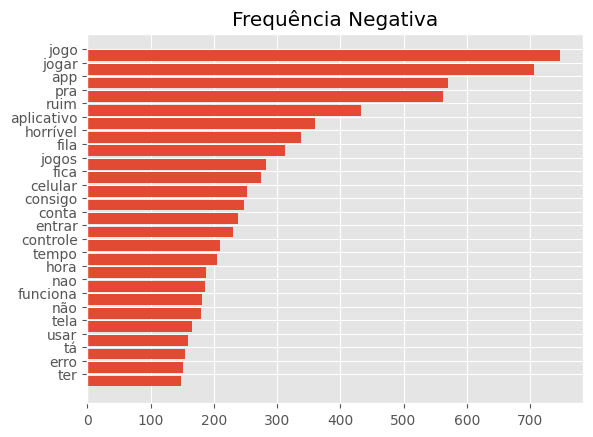

In [31]:
pos_freq = dict(Counter(clean_neg_tokens))
pos_freq.pop('q')
pos_popular_words = sorted(pos_freq, key = pos_freq.get, reverse = True)

plt.barh(range(25), [pos_freq[w] for w in reversed(pos_popular_words[0:25])])
plt.yticks([x + 0.5 for x in range(25)], reversed(pos_popular_words[0:25]))
plt.title('Frequência Negativa')
plt.show()

In [37]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [38]:
nltk.tag.pos_tag(clean_neg_tokens, lang='pt')

NotImplementedError: Currently, NLTK pos_tag only supports English and Russian (i.e. lang='eng' or lang='rus')

In [ ]:
# tentar pegar apenas adjetivos para retornar palavras mais utilizadas
# retornar a média das reviews
# criar interação com usuário

## Fontes/Ideias

Análise de sentimentos em português utilizando Pytorch e Python

* [Parte 1](https://medium.com/data-hackers/an%C3%A1lise-de-sentimentos-em-portugu%C3%AAs-utilizando-pytorch-e-python-91a232165ec0)

* [Parte 2](https://medium.com/data-hackers/deploy-de-um-modelo-de-an%C3%A1lise-de-sentimentos-como-uma-rest-api-878c175ad24f)

---

[Construindo um analisador de sentimentos em python](https://acadianschool.com.br/construindo-um-analisador-de-sentimentos-em-python/)

---

[AIpp](https://github.com/TailUFPB/AIpp/tree/main)

---

[tradutor de texto em python](https://www.hashtagtreinamentos.com/tradutor-de-texto-em-python#:~:text=Utilizaremos%20a%20biblioteca%20Deep%2Dtranslator,podemos%20fazer%20no%20pr%C3%B3prio%20site.)